# UHI Data Download and Processing Pipeline

Configured for downloading Sentinel-2b / Landsat-LST mosaics within a bounding box defined by a csv of UHI measurements
Designed to work for NYC but can be extended to other cities. Requires ground-level intraday UHI measurements.

## 1. Setup and Dependencies

In [20]:
import sys
import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
import logging
import requests
import os
from tqdm import tqdm
import subprocess
import zipfile # For more robust unzipping
import time
import pystac_client
import pystac
import planetary_computer
import stackstac
from pathlib import Path
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import cm
import matplotlib.dates as mdates
import ipywidgets as widgets
from ipywidgets import interact, fixed
from IPython.display import display
from datetime import datetime


# Imports for tile index processing
import geopandas as gpd
from shapely.geometry import box

# Add the project root to the Python path to allow importing from src
project_root = Path(os.getcwd()).parent  # Assumes notebook is in 'notebooks' subdir
sys.path.insert(0, str(project_root))

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [9]:

# --- Configuration for Data Download ---

# Configure parameters for the target city (e.g., NYC)
city_name = "NYC"

# Time window matching original notebooks (adjust if needed)
sentinel_time_window = "2021-06-01/2021-09-01"
lst_time_window = "2021-06-01/2021-09-01"

# Input files and general settings
data_dir = Path("data")
abs_output_dir = project_root / data_dir
uhi_csv = data_dir / city_name / "uhi.csv" # Path to UHI data
abs_uhi_csv = project_root / uhi_csv
# bbox_csv is no longer needed for bounds calculation

if not abs_uhi_csv.exists():
    raise FileNotFoundError(f"UHI data CSV not found at {abs_uhi_csv}. Cannot derive bounds.")
print(f"Loading bounds from UHI data: {abs_uhi_csv}")
uhi_df = pd.read_csv(abs_uhi_csv)
# Check if required columns exist
required_cols = ['Longitude', 'Latitude']
if not all(col in uhi_df.columns for col in required_cols):
     raise ValueError(f"UHI CSV must contain columns: {required_cols}")

# Load bounds
bounds = [
    uhi_df['Longitude'].min(),
    uhi_df['Latitude'].min(),
    uhi_df['Longitude'].max(),
    uhi_df['Latitude'].max()
]

# Load observation da
first_datetime_obj = pd.to_datetime(uhi_df['datetime'].iloc[0], format='%d-%m-%Y %H:%M')
# Format the date object into 'YYYY-MM-DD' string format
uhi_date_str = first_datetime_obj.strftime('%Y-%m-%d')
print(f"Representative UHI date (from first row): {uhi_date_str}")

Loading bounds from UHI data: /home/jupyter/MLC-Project/data/NYC/uhi.csv
Representative UHI date (from first row): 2021-07-24


## 2. Download Satellite Data for Cities

Now we'll download satellite imagery data (Sentinel-2 median composites, Landsat LST medians) for specific cities and time periods derived from the UHI data timestamps. Data is saved locally for use by the dataloader.

In [10]:
# Import functions
from src.ingest.get_median import create_and_save_cloudless_mosaic
# Import the modified LST download function
from src.ingest.create_sat_tensor_files import download_single_lst_median
import pandas as pd
from pathlib import Path
import os

# Parameters for Cloudless Mosaic (matching Sentinel2_GeoTIFF.ipynb)
mosaic_bands = ["B02", "B03", "B04", "B08"] # RGB+NIR for Clay compatibility
mosaic_resolution_m = 10
mosaic_cloud_cover = 30

# Parameters for LST Median (matching Landsat_LST.ipynb)
include_lst = False         # Whether to download LST
lst_resolution_m = 30      # Native resolution for Landsat LST

# Generate output path for the mosaic based on the new time window
start_dt_str = sentinel_time_window.split('/')[0].replace('-','')
end_dt_str = sentinel_time_window.split('/')[1].replace('-','')
band_str = "_".join(mosaic_bands)
cloudless_mosaic_filename = f"sentinel_{city_name}_{start_dt_str}_to_{end_dt_str}_cloudless_mosaic.npy"
cloudless_mosaic_path = abs_output_dir / city_name / "sat_files" / cloudless_mosaic_filename
# --- Verification ---
print(f"City: {city_name}")
print(f"Sentinel-2 Time Window: {sentinel_time_window}")
print(f"Sentinel-2 Cloud Cover Threshold: {mosaic_cloud_cover}%")
print(f"LST Time Window: {lst_time_window}")
print(f"Bounds derived from {uhi_csv.name}: {bounds}")
print(f"Target mosaic output path: {cloudless_mosaic_path}")
print(f"Include LST: {include_lst}")


City: NYC
Sentinel-2 Time Window: 2021-06-01/2021-09-01
Sentinel-2 Cloud Cover Threshold: 30%
LST Time Window: 2021-06-01/2021-09-01
Bounds derived from uhi.csv: [np.float64(-73.99445667), np.float64(40.75879167), np.float64(-73.87945833), np.float64(40.85949667)]
Target mosaic output path: /home/jupyter/MLC-Project/data/NYC/sat_files/sentinel_NYC_20210601_to_20210901_cloudless_mosaic.npy
Include LST: False


In [12]:
# --- 1. Generate Cloudless Mosaic --- 
print(f"\n--- Generating Cloudless Mosaic ({sentinel_time_window}) ---")

mosaic_output_path = create_and_save_cloudless_mosaic(
    city_name=city_name,
    bounds=bounds,
    output_dir=abs_output_dir,
    time_window=sentinel_time_window, # Use the explicit time window
    selected_bands=mosaic_bands,
    resolution_m=mosaic_resolution_m,
    cloud_cover=mosaic_cloud_cover # Use the updated cloud cover
)

if mosaic_output_path:
    print(f"Cloudless mosaic saved/found at: {mosaic_output_path}")
else:
    # Stop if mosaic fails, as it's required
    raise RuntimeError("Failed to generate cloudless mosaic.")

# --- 2. Download Single LST Median (if enabled) ---
print(f"\n--- Downloading Single LST Median (Include: {include_lst}, Window: {lst_time_window}) ---")

single_lst_median_file_path = None # Initialize path variable
if include_lst:
    # No need to check UHI CSV, we provide the time window directly
    
    # Download the single LST median using the explicit time window
    single_lst_median_file_path = download_single_lst_median(
        city_name=city_name,
        bounds=bounds,
        output_dir=abs_output_dir,
        time_window=lst_time_window, # Provide explicit window
        # uhi_csv_path and averaging_window are omitted/None
        resolution_m=lst_resolution_m
        # lst_cloud_cover is handled internally by load_lst_tensor_from_bbox_median
    )

    if single_lst_median_file_path:
        print(f"Single LST median saved/found at: {single_lst_median_file_path}")
    else:
        print("Failed to generate single LST median.")
else:
    print("Skipping LST median download as include_lst is False.")

# --- Verification ---
sat_files_check_dir = Path(abs_output_dir) / city_name / "sat_files"
print(f"\nVerifying output files:")
print(f"  Mosaic path ({cloudless_mosaic_path.name}) exists: {cloudless_mosaic_path.exists()}")
if include_lst:
    # Construct expected LST filename based on the explicit window
    lst_start_str = lst_time_window.split('/')[0].replace('-','')
    lst_end_str = lst_time_window.split('/')[1].replace('-','')
    expected_lst_filename = f"lst_{city_name}_median_{lst_start_str}_to_{lst_end_str}.npy"
    expected_lst_path = sat_files_check_dir / expected_lst_filename
    print(f"  Single LST median path ({expected_lst_filename}) exists: {expected_lst_path.exists()}")
    # Update the variable used by later cells if generation was successful
    if single_lst_median_file_path and not single_lst_median_file_path.exists():
         # This case shouldn't happen if the function worked, but good sanity check
         print(f"Warning: LST download function returned a path but it doesn't exist: {single_lst_median_file_path}")
         single_lst_median_file_path = None # Ensure later cells know it failed
    elif not single_lst_median_file_path and expected_lst_path.exists():
         # File existed previously, update path variable for later cells
         single_lst_median_file_path = expected_lst_path


2025-05-06 20:41:04,996 - INFO - Generating cloudless mosaic for NYC, window 2021-06-01/2021-09-01...



--- Generating Cloudless Mosaic (2021-06-01/2021-09-01) ---


2025-05-06 20:41:05,766 - INFO - Found 10 Sentinel-2 items. Checking for GCPs...
2025-05-06 20:41:05,767 - INFO - Using temporary directory for gdalwarp: /var/tmp/gdal_preprocess_bvc33zln
2025-05-06 20:41:05,820 - INFO - Loading data with odc.stac.stac_load on 10 items...
2025-05-06 20:41:05,821 - INFO -   Pre-load check for item 1/10: ID S2A_MSIL2A_20210813T154911_R054_T18TWL_20210814T063950
2025-05-06 20:41:05,823 - INFO -     Item S2A_MSIL2A_20210813T154911_R054_T18TWL_20210814T063950, Band B02: href=https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/18/T/WL/2021/08/13/S2A_MSIL2A_20210813T154911_N0300_R054_T18TWL_20210814T063950.SAFE/GRANULE/L2A_T18TWL_A032083_20210813T155956/IMG_DATA/R10m/T18TWL_20210813T154911_B02_10m.tif?st=2025-05-05T20%3A31%3A54Z&se=2025-05-06T21%3A16%3A54Z&sp=rl&sv=2024-05-04&sr=c&skoid=9c8ff44a-6a2c-4dfb-b298-1c9212f64d9a&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2025-05-06T13%3A54%3A36Z&ske=2025-05-13T13%3A54%3A36Z&sks=b&skv=2024-05-04&sig=C8xqmt

Cloudless mosaic saved/found at: /home/jupyter/MLC-Project/data/NYC/sat_files/sentinel_NYC_20210601_to_20210901_cloudless_mosaic.npy

--- Downloading Single LST Median (Include: False, Window: 2021-06-01/2021-09-01) ---
Skipping LST median download as include_lst is False.

Verifying output files:
  Mosaic path (sentinel_NYC_20210601_to_20210901_cloudless_mosaic.npy) exists: True


Mosaic shape: (4, 1119, 1278)


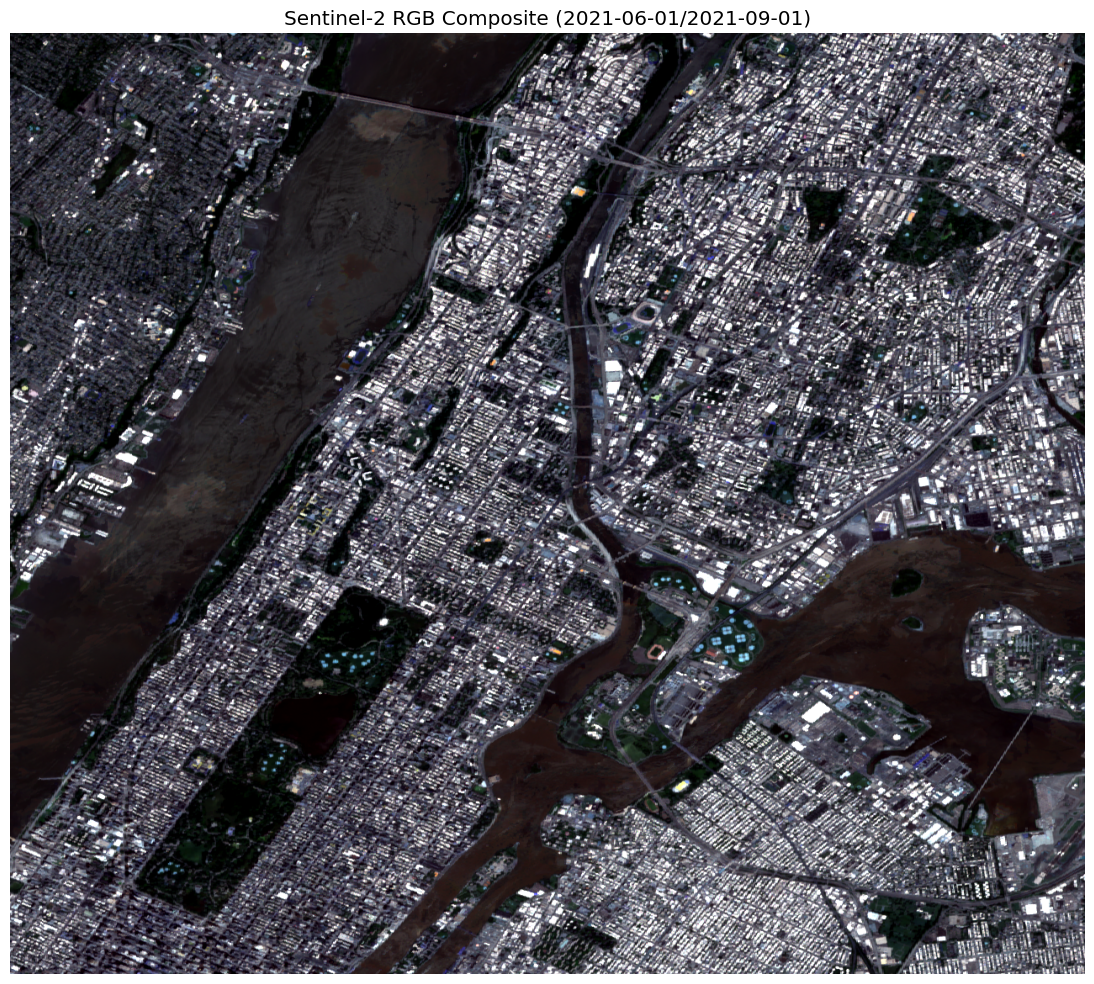

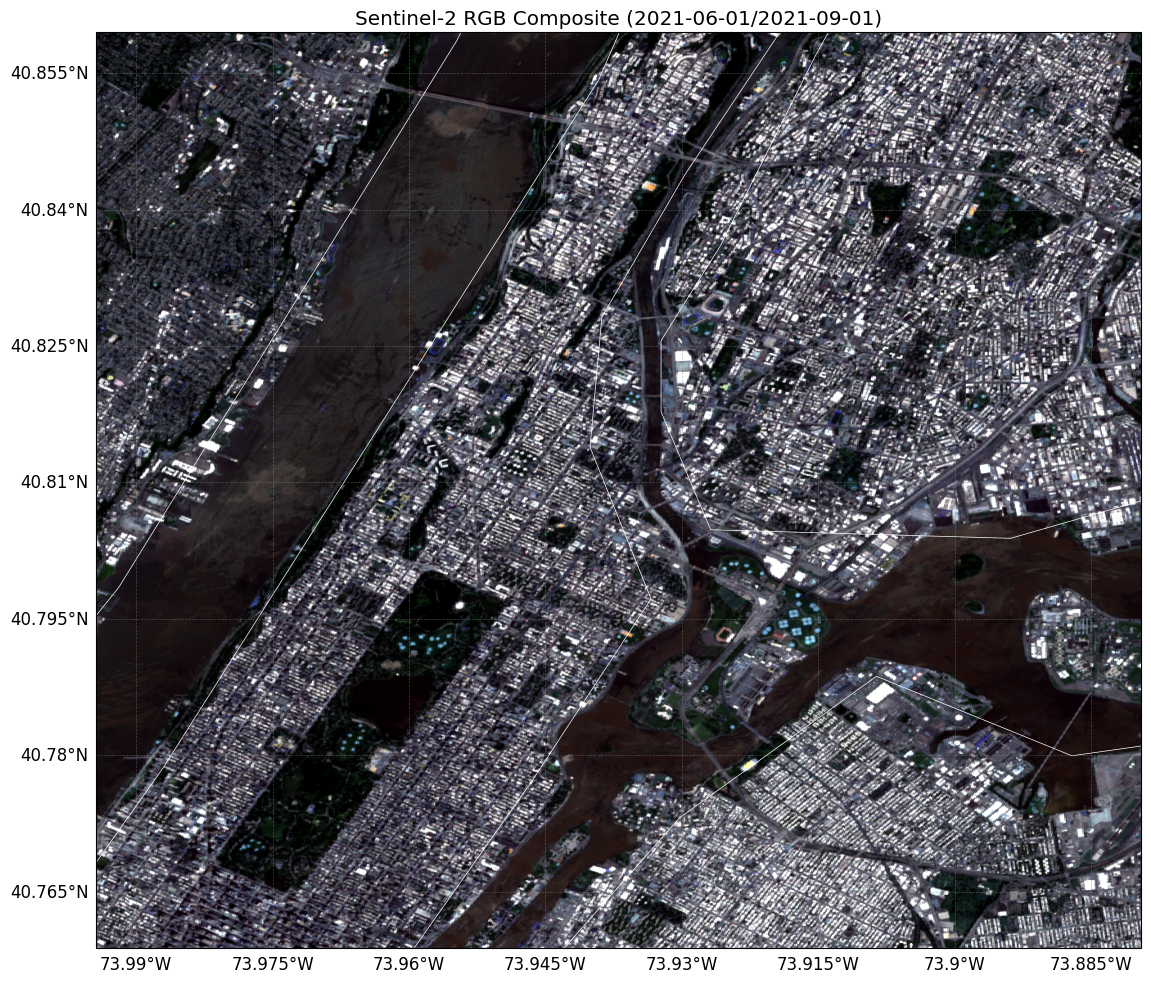

In [21]:
# --- Combined Visualization: Sentinel-2 RGB with UHI Values Overlay (Cartopy) ---
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import numpy.ma as ma
import ipywidgets as widgets
from ipywidgets import interact, fixed
from IPython.display import display
from datetime import datetime

# --- Load Data ---
# Sentinel-2 Cloudless Mosaic
sat_files_dir = abs_output_dir / city_name / "sat_files"
mosaic_path = sat_files_dir / f"sentinel_{city_name}_{sentinel_time_window.split('/')[0].replace('-', '')}_to_{sentinel_time_window.split('/')[1].replace('-', '')}_cloudless_mosaic.npy"
mosaic = np.load(mosaic_path)
print(f"Mosaic shape: {mosaic.shape}")  # Should be (4, H, W) for bands

# UHI Data
uhi_df = pd.read_csv(abs_uhi_csv)
print(f"UHI data shape: {uhi_df.shape}")

# --- Process RGB Data ---
if mosaic.shape[0] >= 3:
    # Get RGB bands (first 3 bands should be B, G, R)
    rgb = mosaic[:3]  # Blue, Green, Red
    
    # Transpose to (H, W, 3) for visualization
    rgb = np.transpose(rgb, (1, 2, 0))
    
    # Create masked array for NaN values in RGB
    rgb_masked = ma.masked_invalid(rgb)
    
    # Normalize for visualization (adjust as needed)
    rgb_norm = np.zeros_like(rgb, dtype=np.float32)
    for i in range(3):
        # Get valid min/max, ignoring NaN values
        valid_data = rgb[:, :, i][~np.isnan(rgb[:, :, i])]
        if len(valid_data) > 0:
            p2, p98 = np.percentile(valid_data, (2, 98))
            channel_norm = np.clip((rgb[:, :, i] - p2) / (p98 - p2), 0, 1)
            # Preserve NaN values in normalized data
            rgb_norm[:, :, i] = np.where(np.isnan(rgb[:, :, i]), np.nan, channel_norm)
        else:
            print(f"Warning: Channel {i} contains only NaN values")
    
    # --- Process UHI Data with Timestamps ---
    # Check for timestamp column (may be named datetime or timestamp)
    timestamp_col = 'datetime' if 'datetime' in uhi_df.columns else 'timestamp'
    
    if timestamp_col in uhi_df.columns:
        # Convert timestamps to datetime
        try:
            if isinstance(uhi_df[timestamp_col].iloc[0], str):
                try:
                    # Try common formats
                    uhi_df['datetime_processed'] = pd.to_datetime(uhi_df[timestamp_col], format='%d-%m-%Y %H:%M')
                except ValueError:
                    try:
                        uhi_df['datetime_processed'] = pd.to_datetime(uhi_df[timestamp_col])
                    except:
                        print(f"Could not parse timestamps from {timestamp_col} column")
            else:
                uhi_df['datetime_processed'] = pd.to_datetime(uhi_df[timestamp_col])
            
            # Get unique timestamps for the slider
            unique_timestamps = sorted(uhi_df['datetime_processed'].unique())
            timestamp_options = [(ts.strftime('%Y-%m-%d %H:%M'), ts) for ts in unique_timestamps]
            
            print(f"Found {len(unique_timestamps)} unique timestamps")
        except Exception as e:
            print(f"Error processing timestamps: {e}")
            unique_timestamps = [datetime.now()]
            timestamp_options = [("No timestamp data", datetime.now())]
    else:
        print(f"No timestamp column found. Expected '{timestamp_col}'")
        unique_timestamps = [datetime.now()]
        timestamp_options = [("No timestamp data", datetime.now())]
    
    # --- Set Grid Resolution for UHI Data ---
    grid_resolution_m = 200  # Grid cell size in meters (adjust as needed)
    
    # Convert meters to degrees approximately
    lon_center = (bounds[0] + bounds[2]) / 2
    lat_degree_per_meter = 1 / 111000  # Approximate degrees latitude per meter
    lon_degree_per_meter = 1 / (111000 * np.cos(np.radians(lon_center)))  # Approximate degrees longitude per meter
    
    # Convert resolution to degree units
    lat_resolution = grid_resolution_m * lat_degree_per_meter
    lon_resolution = grid_resolution_m * lon_degree_per_meter
    
    # --- Create Grid for UHI Data ---
    # Define grid boundaries
    lon_min, lat_min, lon_max, lat_max = bounds
    lon_grid = np.arange(lon_min, lon_max + lon_resolution, lon_resolution)
    lat_grid = np.arange(lat_min, lat_max + lat_resolution, lat_resolution)
    
    print(f"Grid size: {len(lon_grid)} x {len(lat_grid)} cells")
    print(f"Grid cell size: ~{grid_resolution_m}m ({lon_resolution:.6f}° x {lat_resolution:.6f}°)")
    
    # --- Function to update plot based on timestamp ---
    def update_plot(timestamp, grid_resolution_m=grid_resolution_m):
        # Filter data for selected timestamp
        if 'datetime_processed' in uhi_df.columns:
            timestamp_data = uhi_df[uhi_df['datetime_processed'] == timestamp]
        else:
            timestamp_data = uhi_df  # Use all data if no timestamp column
        
        if len(timestamp_data) == 0:
            print(f"No data for timestamp {timestamp}")
            return
        
        # Bin data into grid for the specific timestamp
        grid_values = np.zeros((len(lat_grid)-1, len(lon_grid)-1)) * np.nan
        grid_counts = np.zeros((len(lat_grid)-1, len(lon_grid)-1))
        
        # Identify UHI column
        uhi_column = None
        for col in ['UHI', 'delta_T', 'UHI Index']:
            if col in timestamp_data.columns:
                uhi_column = col
                break
        
        if uhi_column is None:
            print("No UHI value column found (looked for 'UHI', 'delta_T', 'UHI Index')")
            return
        
        # Bin the UHI points into grid cells
        for _, row in timestamp_data.iterrows():
            try:
                lon_idx = np.searchsorted(lon_grid, row['Longitude']) - 1
                lat_idx = np.searchsorted(lat_grid, row['Latitude']) - 1
                
                # Only count points that fall within grid bounds
                if 0 <= lon_idx < len(lon_grid)-1 and 0 <= lat_idx < len(lat_grid)-1:
                    uhi_value = row[uhi_column]
                    
                    # Add value to grid for averaging (only if it's a valid number)
                    if np.isfinite(uhi_value):
                        if np.isnan(grid_values[lat_idx, lon_idx]):
                            grid_values[lat_idx, lon_idx] = uhi_value
                        else:
                            grid_values[lat_idx, lon_idx] += uhi_value
                        
                        grid_counts[lat_idx, lon_idx] += 1
            except Exception as e:
                print(f"Error binning point {row['Longitude']}, {row['Latitude']}: {e}")
        
        # Calculate average for each cell
        with np.errstate(divide='ignore', invalid='ignore'):
            grid_avg = np.divide(grid_values, grid_counts, where=grid_counts > 0)
        
        # --- Create Cartopy Visualization ---
        try:
            import cartopy.crs as ccrs
            from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
            
            # Set up the figure and projection
            plt.figure(figsize=(12, 10))
            ax = plt.axes(projection=ccrs.PlateCarree())
            
            # Define the extent
            extent = [bounds[0], bounds[2], bounds[1], bounds[3]]
            
            # 1. Plot the RGB Sentinel image
            # Create masked RGB for proper NaN handling
            rgb_masked = ma.masked_invalid(rgb_norm)
            ax.imshow(rgb_masked, origin='upper', extent=extent, transform=ccrs.PlateCarree())
            
            # 2. Plot UHI grid values as semi-transparent overlay
            # Create a masked array to handle NaN values with transparency
            grid_masked = ma.masked_invalid(grid_avg)
            
            # Create mesh grid for pcolormesh
            lon_mesh, lat_mesh = np.meshgrid(lon_grid, lat_grid)
            
            # Plot only cells with valid data
            mesh = ax.pcolormesh(
                lon_grid, lat_grid, 
                grid_masked,
                cmap='coolwarm',
                alpha=0.7,
                transform=ccrs.PlateCarree(),
                shading='auto'
            )
            
            # Add coastlines, borders, and gridlines
            ax.coastlines(resolution='10m', color='white', linewidth=0.5)
            gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
            gl.top_labels = False
            gl.right_labels = False
            gl.xformatter = LONGITUDE_FORMATTER
            gl.yformatter = LATITUDE_FORMATTER
            
            # Add colorbar
            cbar = plt.colorbar(mesh, ax=ax, shrink=0.7)
            cbar.set_label(f'UHI Intensity (°C)')
            
            # Format timestamp for title
            if isinstance(timestamp, (pd.Timestamp, datetime)):
                title_timestamp = timestamp.strftime('%Y-%m-%d %H:%M')
            else:
                title_timestamp = str(timestamp)
            
            # Add title
            plt.title(f'UHI Grid ({grid_resolution_m}m) Over Sentinel-2 RGB\n{title_timestamp} - {city_name}')
            
            # Add text showing data points
            ax.text(
                0.02, 0.02, 
                f"Grid resolution: {grid_resolution_m}m | Data points: {len(timestamp_data)}",
                transform=ax.transAxes,
                bbox={"facecolor":"white", "alpha":0.7, "pad":5},
                fontsize=10
            )
            
            plt.tight_layout()
            plt.show()
            
        except ImportError as e:
            print(f"Cartopy not available or error: {e}. Defaulting to basic Matplotlib.")
            
            # --- Create basic matplotlib visualization ---
            fig, ax = plt.subplots(figsize=(12, 10))
            
            # Plot RGB background
            ax.imshow(rgb_masked, extent=extent)
            
            # Create a masked array to handle NaN values with transparency
            grid_masked = ma.masked_invalid(grid_avg)
            
            # Create mesh grid for pcolormesh
            lon_mesh, lat_mesh = np.meshgrid(lon_grid, lat_grid)
            
            # Plot UHI values
            mesh = ax.pcolormesh(
                lon_grid, lat_grid, 
                grid_masked,
                cmap='coolwarm',
                alpha=0.7,
                shading='auto'
            )
            
            # Add colorbar
            cbar = plt.colorbar(mesh, ax=ax, shrink=0.7)
            cbar.set_label(f'UHI Intensity (°C)')
            
            # Format timestamp for title
            if isinstance(timestamp, (pd.Timestamp, datetime)):
                title_timestamp = timestamp.strftime('%Y-%m-%d %H:%M')
            else:
                title_timestamp = str(timestamp)
            
            # Add title and labels
            ax.set_title(f'UHI Grid ({grid_resolution_m}m) Over Sentinel-2 RGB\n{title_timestamp} - {city_name}')
            ax.set_xlabel('Longitude')
            ax.set_ylabel('Latitude')
            
            # Set axis limits to match the bounds
            ax.set_xlim(bounds[0], bounds[2])
            ax.set_ylim(bounds[1], bounds[3])
            
            # Add grid
            ax.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
    
    # --- Create and display the time selection widget ---
    if len(timestamp_options) > 0:
        # Create dropdown widget
        timestamp_dropdown = widgets.Dropdown(
            options=timestamp_options,
            description='Timestamp:',
            style={'description_width': 'initial'},
            layout=widgets.Layout(width='50%')
        )
        
        # Display interactive widget
        interact(update_plot, timestamp=timestamp_dropdown, grid_resolution_m=fixed(grid_resolution_m))
    else:
        print("No timestamp data available for slider")
        # Run once with all data
        update_plot(None, grid_resolution_m)
else:
    print(f"Not enough bands for RGB visualization. Mosaic has {mosaic.shape[0]} bands.")

In [22]:
# This cell is now merged with the previous visualization cell

UHI data shape: (11229, 4)
Found 59 unique timestamps
Grid size: 19 x 57 cells
Grid cell size: ~200m (0.006512° x 0.001802°)


interactive(children=(Dropdown(description='Timestamp:', layout=Layout(width='50%'), options=(('2021-07-24 15:…

### 3. Download + Build DEM (DTM) / DSM for NYC from planetary computer

In [16]:
# ─────────────────────────────────────────────────────────────────────────────
# CONFIG
# ─────────────────────────────────────────────────────────────────────────────
# DEM/DSM specific settings
# Fetching BOTH DEM and DSM from Planetary Computer

# --- URLs and Paths ---
CRS_WGS84 = "EPSG:4326"

# Ensure the 'sat_files' directory exists
sat_files_dir = abs_output_dir / city_name / "sat_files"
sat_files_dir.mkdir(parents=True, exist_ok=True)

# --- Target Resolution --- # 
TARGET_ELEV_RESOLUTION_M = 10 # Target resolution in meters (downloading source 1m files make dataloading to the model extremely slow)
# Approximate 10m in degrees at NYC latitude (approx 40.7 N)
# Latitude: 1 deg ~ 111 km => 10m ~ 0.00009 deg
# Longitude: 1 deg ~ 85 km => 10m ~ 0.000118 deg
# Using the latitude approximation for stackstac resolution parameter
TARGET_ELEV_RESOLUTION_DEG = 0.00009 

# --- Define final expected TIF paths --- #
# UPDATED Filenames to reflect 10m resolution
final_dem_path_tif = sat_files_dir / f"nyc_dem_{TARGET_ELEV_RESOLUTION_M}m_pc.tif" 
final_dsm_path_tif = sat_files_dir / f"nyc_dsm_{TARGET_ELEV_RESOLUTION_M}m_pc.tif"

# --- Define nodata value --- #
ELEV_NODATA_VALUE = np.nan # Use a float value for both

# --- Download DEM from Planetary Computer --- #
print(f"\n--- Downloading DEM from Planetary Computer at approx {TARGET_ELEV_RESOLUTION_M}m resolution ---")
dem_downloaded_pc = False
if final_dem_path_tif.exists():
    logging.info(f"DEM file {final_dem_path_tif.name} already exists. Skipping download.")
    dem_downloaded_pc = True
else:
    try:
        # Ensure necessary libraries are imported (should be in cell 2)
        import pystac_client
        import planetary_computer
        import stackstac
        import rioxarray
        import numpy as np

        # Define bounding box and CRS for STAC query
        bbox = bounds # Use the same bounds calculated earlier
        logging.info(f"Using bounding box for DEM query: {bbox}")

        # Search the 3dep-lidar-DTM collection (DEM)
        catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1", modifier=planetary_computer.sign_inplace)
        search_dem = catalog.search(
            collections=["3dep-lidar-dtm"], # Use DTM collection
            bbox=bbox,
        )
        items_dem = search_dem.item_collection()
        logging.info(f"Found {len(items_dem)} 3DEP DTM (DEM) items for the bounding box.")

        if not items_dem:
            logging.warning("No 3DEP DTM (DEM) items found for the specified area. Cannot download DEM.")
        else:
            # Load items, mean aggregate time, select the single band, then squeeze
            logging.info(f"Requesting DEM data from stackstac at resolution: {TARGET_ELEV_RESOLUTION_DEG} degrees")
            dem_data = stackstac.stack(
                items_dem,
                assets=["data"],
                epsg=4326,
                resolution=TARGET_ELEV_RESOLUTION_DEG, # Use target 10m resolution in degrees
                dtype=np.float64, # Save directly as float32
                fill_value=ELEV_NODATA_VALUE,
                rescale=False,
                bounds_latlon=bbox
            ).mean("time", skipna=True) # Aggregate time first

            # Explicitly select the single 'data' band if 'band' dimension exists
            if "band" in dem_data.dims:
                dem_data = dem_data.isel(band=0)

            # Squeeze any remaining singleton dimensions
            dem_data = dem_data.squeeze()

            logging.info(f"Created DEM xarray with shape: {dem_data.shape} and dtype: {dem_data.dtype}")

            # Assign CRS if missing
            if dem_data.rio.crs is None:
                 logging.warning("Assigning CRS EPSG:4326 to DEM data as it was missing after stackstac.")
                 dem_data = dem_data.rio.write_crs(CRS_WGS84)

            # Set nodata value explicitly for writing
            dem_data.rio.write_nodata(ELEV_NODATA_VALUE, inplace=True)

            # Save the DataArray to a GeoTIFF (Filename now reflects 10m)
            logging.info(f"Saving DEM to {final_dem_path_tif}...")
            dem_data.rio.to_raster(final_dem_path_tif, driver="COG") 
            logging.info("Successfully downloaded and saved DEM from Planetary Computer.")
            dem_downloaded_pc = True
            del dem_data # Clean up memory

    except ImportError as e:
        logging.error(f"Missing libraries for Planetary Computer access ({e}). Please install: pystac-client planetary-computer stackstac rioxarray numpy")
    except Exception as e:
        logging.error(f"An error occurred during Planetary Computer DEM download: {e}", exc_info=True)

# --- Download DSM from Planetary Computer --- #
print(f"\n--- Downloading DSM from Planetary Computer at approx {TARGET_ELEV_RESOLUTION_M}m resolution ---")
dsm_downloaded_pc = False
if final_dsm_path_tif.exists():
    logging.info(f"DSM file {final_dsm_path_tif.name} already exists. Skipping download.")
    dsm_downloaded_pc = True
else:
    try:
        # Libraries should be imported already
        import pystac_client
        import planetary_computer
        import stackstac
        import rioxarray
        import numpy as np

        bbox = bounds # Use the same bounds
        logging.info(f"Using bounding box for DSM query: {bbox}")

        # Search the 3dep-lidar-dsm collection
        catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1", modifier=planetary_computer.sign_inplace)
        search_dsm = catalog.search(
            collections=["3dep-lidar-dsm"],
            bbox=bbox,
        )
        items_dsm = search_dsm.item_collection()
        logging.info(f"Found {len(items_dsm)} 3DEP DSM items for the bounding box.")

        if not items_dsm:
            logging.warning("No 3DEP DSM items found for the specified area. Cannot download DSM.")
        else:
            # Load items, mean aggregate time, select the single band, then squeeze
            logging.info(f"Requesting DSM data from stackstac at resolution: {TARGET_ELEV_RESOLUTION_DEG} degrees")
            dsm_data = stackstac.stack(
                items_dsm,
                assets=["data"],
                epsg=4326,
                resolution=TARGET_ELEV_RESOLUTION_DEG, # Use target 10m resolution in degrees
                dtype=np.float64, # Save directly as float32
                fill_value=ELEV_NODATA_VALUE,
                rescale=False,
                bounds_latlon=bbox
            ).mean("time", skipna=True) # Aggregate time first

            # Explicitly select the single 'data' band if 'band' dimension exists
            if "band" in dsm_data.dims:
                dsm_data = dsm_data.isel(band=0)

            # Squeeze any remaining singleton dimensions
            dsm_data = dsm_data.squeeze()

            logging.info(f"Created DSM xarray with shape: {dsm_data.shape} and dtype: {dsm_data.dtype}")

            # Assign CRS if missing
            if dsm_data.rio.crs is None:
                 logging.warning("Assigning CRS EPSG:4326 to DSM data as it was missing after stackstac.")
                 dsm_data = dsm_data.rio.write_crs(CRS_WGS84)

            # Set nodata value explicitly for writing
            dsm_data.rio.write_nodata(ELEV_NODATA_VALUE, inplace=True)

            # Save the DataArray to a GeoTIFF (Filename now reflects 10m)
            logging.info(f"Saving DSM to {final_dsm_path_tif}...")
            dsm_data.rio.to_raster(final_dsm_path_tif, driver="COG") 
            logging.info("Successfully downloaded and saved DSM from Planetary Computer.")
            dsm_downloaded_pc = True
            del dsm_data # Clean up memory

    except ImportError as e:
        logging.error(f"Missing libraries for Planetary Computer access ({e}). Please install: pystac-client planetary-computer stackstac rioxarray numpy")
    except Exception as e:
        logging.error(f"An error occurred during Planetary Computer DSM download: {e}", exc_info=True)

# --- Update Relative Paths for Config ---
dem_path_relative = Path("data") / city_name / "sat_files" / final_dem_path_tif.name
dsm_path_relative = Path("data") / city_name / "sat_files" / final_dsm_path_tif.name
print(f"\nRelative paths for config (relative to project root '{project_root}'):")
print(f"  DEM: {dem_path_relative}")
print(f"  DSM: {dsm_path_relative}")

# --- Final Check ---
print("\n--- Final Status ---")
if final_dem_path_tif.exists():
    print(f"DEM file exists: {final_dem_path_tif}")
else:
    print("DEM file NOT found.")
if final_dsm_path_tif.exists():
    print(f"DSM file exists: {final_dsm_path_tif}")
else:
    print("DSM file NOT found.")


2025-05-06 20:42:57,363 - INFO - DEM file nyc_dem_10m_pc.tif already exists. Skipping download.
2025-05-06 20:42:57,365 - INFO - Using bounding box for DSM query: [np.float64(-73.99445667), np.float64(40.75879167), np.float64(-73.87945833), np.float64(40.85949667)]



--- Downloading DEM from Planetary Computer at approx 10m resolution ---

--- Downloading DSM from Planetary Computer at approx 10m resolution ---


2025-05-06 20:43:00,473 - INFO - Found 5 3DEP DSM items for the bounding box.
2025-05-06 20:43:00,474 - INFO - Requesting DSM data from stackstac at resolution: 9e-05 degrees
2025-05-06 20:43:00,487 - INFO - Created DSM xarray with shape: (1120, 1279) and dtype: float64
2025-05-06 20:43:00,488 - WARNING - Assigning CRS EPSG:4326 to DSM data as it was missing after stackstac.
2025-05-06 20:43:00,491 - INFO - Saving DSM to /home/jupyter/MLC-Project/data/NYC/sat_files/nyc_dsm_10m_pc.tif...
2025-05-06 20:43:02,622 - INFO - Successfully downloaded and saved DSM from Planetary Computer.



Relative paths for config (relative to project root '/home/jupyter/MLC-Project'):
  DEM: data/NYC/sat_files/nyc_dem_10m_pc.tif
  DSM: data/NYC/sat_files/nyc_dsm_10m_pc.tif

--- Final Status ---
DEM file exists: /home/jupyter/MLC-Project/data/NYC/sat_files/nyc_dem_10m_pc.tif
DSM file exists: /home/jupyter/MLC-Project/data/NYC/sat_files/nyc_dsm_10m_pc.tif


In [ ]:
# This cell is already incorporated into cell 8